In [83]:
import pandas as pd
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import confint_proportions_2indep


In [84]:
order_patterns = ["decrease", "increase", "stable"]
order_frames = ["diagnostic", "prognotic", "motivational", "community", "engagement"]

In [85]:
def compute_confidence_offset(losing_deltas, winning_deltas, order_patterns, order_frames, alpha=0.05):
    confidence_offset = []

    for pattern in order_patterns:
        for frame in order_frames:
            pattern_losing_sub = losing_deltas[
                (losing_deltas['delta_diff_category'] == pattern) & 
                (losing_deltas['frame'] == frame)
            ]
            total_cases_losing = losing_deltas[ 
                (losing_deltas['frame'] == frame)
            ].shape[0]
            cluster_size_losing = pattern_losing_sub.shape[0]

            pattern_winning_sub = winning_deltas[
                (winning_deltas['delta_diff_category'] == pattern) & 
                (winning_deltas['frame'] == frame)
            ]
            total_cases_winning = winning_deltas[ 
                (winning_deltas['frame'] == frame)
            ].shape[0]
            cluster_size_winning = pattern_winning_sub.shape[0]

            # proportions
            p_losing = cluster_size_losing / total_cases_losing if total_cases_losing > 0 else 0
            p_winning = cluster_size_winning / total_cases_winning if total_cases_winning > 0 else 0

            # difference
            difference_p = p_losing - p_winning
            
            # Newcombe-Wilson CI for difference
            if total_cases_losing > 0 and total_cases_winning > 0:
                lower_ci, upper_ci = confint_proportions_2indep(
                    count1=cluster_size_losing, nobs1=total_cases_losing,
                    count2=cluster_size_winning, nobs2=total_cases_winning,
                    method="newcomb", # basically wilson on p1 and p2 and then conservative combination of bounds
                    compare='diff',
                    alpha=alpha
                )
            else:
                lower_ci, upper_ci = (None, None)  # not enough data

            confidence_offset.append([pattern, frame, difference_p, lower_ci, upper_ci])

    confidence_offset = pd.DataFrame(
        confidence_offset, 
        columns=['pattern', 'frame', 'proportion_diff', 'lower_ci', 'upper_ci']
    )

    return confidence_offset

# All cases

In [ ]:
# import data
losing_deltas = pd.read_pickle(f"../data/deltas_5_Losing Election_withcategories.pkl")

winning_deltas = pd.read_pickle(f"../data/deltas_5_Winning Election_withcategories.pkl")

In [87]:
losing_deltas["frame"] = losing_deltas["frame_prop"].apply(lambda x: x.split("_")[1])
winning_deltas["frame"] = winning_deltas["frame_prop"].apply(lambda x: x.split("_")[1])

In [88]:
losing_deltas["outcome"] = "Losing"
winning_deltas["outcome"] = "Winning"

deltas_all = pd.concat([losing_deltas, winning_deltas], ignore_index=True)

In [89]:
# for each main union, balance the number of cases in losing and winning
list_union_cases = []
for union in deltas_all["main_union"].unique():
    # get losing and winning cases for this union
    losing_cases = deltas_all[(deltas_all["main_union"] == union) & (deltas_all["frame_prop"]=="rolling_community_prop") & (deltas_all["outcome"] == "Losing")]["case_number"].unique()
    winning_cases = deltas_all[(deltas_all["main_union"] == union) & (deltas_all["frame_prop"]=="rolling_community_prop") & (deltas_all["outcome"] == "Winning")]["case_number"].unique()

    cases_winning_sub = pd.Series(winning_cases).sample(n=len(losing_cases), random_state=42).tolist() if len(winning_cases) > len(losing_cases) else list(winning_cases)
    cases_losing_sub = pd.Series(losing_cases).sample(n=len(winning_cases), random_state=42).tolist() if len(losing_cases) > len(winning_cases) else list(losing_cases)

    list_union_cases += [(union, case, "Winning") for case in cases_winning_sub]
    list_union_cases += [(union, case, "Losing") for case in cases_losing_sub]


In [90]:
deltas_all_sampled = deltas_all[deltas_all.apply(lambda row: (row["main_union"], row["case_number"], row["outcome"]) in list_union_cases, axis=1)].copy()

In [91]:
losing_deltas_sampled = deltas_all_sampled[deltas_all_sampled["outcome"] == "Losing"]
winning_deltas_sampled = deltas_all_sampled[deltas_all_sampled["outcome"] == "Winning"]

In [92]:
confidence_offset = compute_confidence_offset(losing_deltas_sampled, winning_deltas_sampled, order_patterns, order_frames)

In [93]:
# Pivot to match your heatmap format
heatmap_data = confidence_offset.pivot(index="pattern", columns="frame", values="proportion_diff")
heatmap_data = heatmap_data.reindex(order_frames, axis=1)

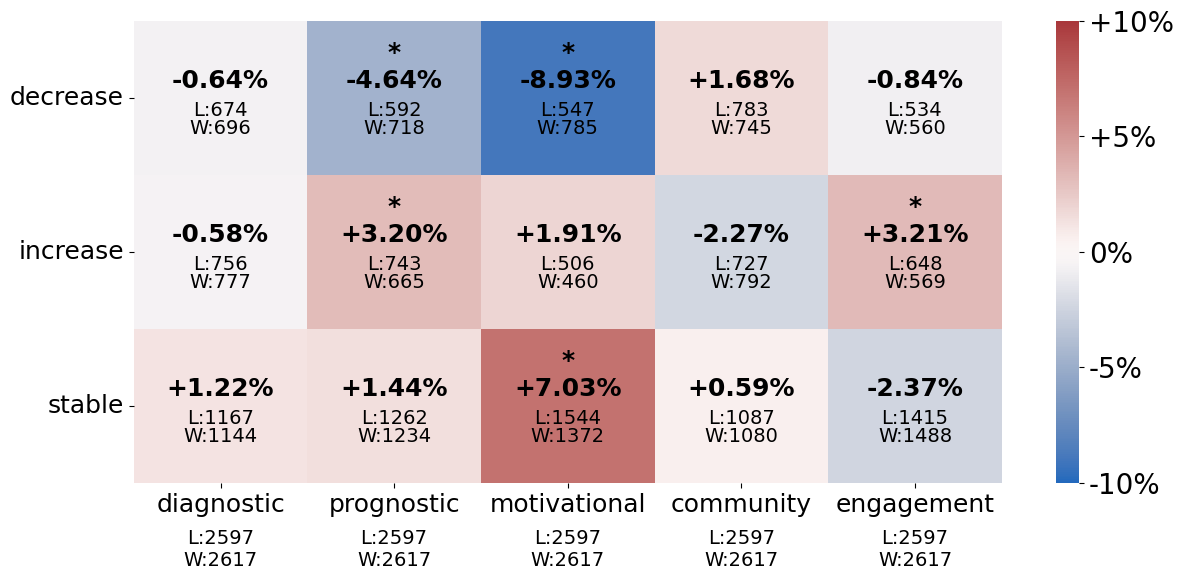

In [ ]:
plt.figure(figsize=(14,6))
ax = sns.heatmap(
    heatmap_data, annot=False, fmt="", cmap="vlag",
    vmin=-0.1, vmax=0.1, center=0
)

# get the colorbar and relabel ticks
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.10, -0.05, 0, 0.05, 0.10])
colorbar.set_ticklabels(["-10%", "-5%", "0%", "+5%", "+10%"], fontsize=20)

# rotate ticks
ax.set_xticklabels(["diagnostic", "prognostic", "motivational", "community", "engagement"], rotation=0, fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)

# add custom annotations
for i, pattern in enumerate(heatmap_data.index):
    for j, frame in enumerate(heatmap_data.columns):
        row = confidence_offset[
            (confidence_offset["pattern"] == pattern) &
            (confidence_offset["frame"] == frame)
        ].iloc[0]

        offset = row["proportion_diff"]
        lower_ci, upper_ci = row["lower_ci"], row["upper_ci"]

        # star if CI excludes 0
        star = "*" if (lower_ci > 0 or upper_ci < 0) else ""

        # add offset + star in bold
        ax.text(
            j + 0.5, i + 0.3,  # slightly above center
            f"{star}\n{offset*100:+.2f}%",
            color="black", ha="center", va="center", fontweight="bold", fontsize=18
        )

        # Optionally: add losing/winning counts as before
        losing = losing_deltas_sampled[(losing_deltas_sampled['frame'] == frame)&(losing_deltas_sampled['delta_diff_category'] == pattern)].shape[0]
        winning = winning_deltas_sampled[(winning_deltas_sampled['frame'] == frame)&(winning_deltas_sampled['delta_diff_category'] == pattern)].shape[0]
        ax.text(j + 0.5, i + 0.58, f"L:{losing}", color="black", ha="center", va="center", fontsize=14)
        ax.text(j + 0.5, i + 0.70, f"W:{winning}", color="black", ha="center", va="center", fontsize=14)

# add totals beneath x tick labels
for xtick, frame in zip(ax.get_xticks(), heatmap_data.columns):
    losing_total = losing_deltas_sampled[(losing_deltas_sampled['frame'] == frame)].shape[0]
    winning_total = winning_deltas_sampled[(winning_deltas_sampled['frame'] == frame)].shape[0]
    ax.text(
        xtick,
        len(heatmap_data) + 0.3,
        f"L:{losing_total}\nW:{winning_total}",
        ha="center", va="top", fontsize=14
    )


#title
plt.title("")
# remove x and y axis label
plt.xlabel("")
plt.ylabel("")
# plt.show()
plt.savefig("../plots/usage_before-after-balanced.svg", bbox_inches='tight')

# Robustness

## Remove over-represented unions

In [95]:
order_patterns = ["decrease", "increase", "stable"]
order_frames = ["diagnostic", "prognotic", "motivational", "community", "engagement"]

In [ ]:
def plot_heatmap_robust(summary, losing_deltas_list, winning_deltas_list, order_patterns, order_frames,significance_threshold=0.8):

    # reshape to matrix for heatmap
    heatmap_matrix = summary.pivot(index="pattern", columns="frame", values="mean_diff")

    # fix patterns and frames order
    heatmap_matrix = heatmap_matrix.reindex(order_patterns, axis=0)
    heatmap_matrix = heatmap_matrix.reindex(order_frames, axis=1)

    
    plt.figure(figsize=(14,6))
    ax = sns.heatmap(
        heatmap_matrix, annot=False, fmt="", cmap="vlag",
        vmin=-0.1, vmax=0.1, center=0
    )

    # get the colorbar and relabel ticks
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.10, -0.05, 0, 0.05, 0.10])
    colorbar.set_ticklabels(["-10%", "-5%", "0%", "+5%", "+10%"], fontsize=20)

    # rotate ticks
    ax.set_xticklabels(["diagnostic", "prognostic", "motivational", "community", "engagement"], rotation=0, fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)

    # add annotations
    for i, pattern in enumerate(heatmap_matrix.index):
        for j, frame in enumerate(heatmap_matrix.columns):
            row = summary[(summary["pattern"]==pattern)&(summary["frame"]==frame)].iloc[0]
            offset = row["mean_diff"]
            star = "*" if row["prop_significant"] >= significance_threshold else ""

            # add offset + star in bold
            ax.text(
                j + 0.5, i + 0.3,  # slightly above center
                f"{star}\n{offset*100:+.2f}%",
                color="black", ha="center", va="center", fontweight="bold", fontsize=18
            )

            # Optionally: show average counts over seeds
            losing_counts = [df[(df['frame']==frame)&(df['delta_diff_category']==pattern)].shape[0] for df in losing_deltas_list]
            winning_counts = [df[(df['frame']==frame)&(df['delta_diff_category']==pattern)].shape[0] for df in winning_deltas_list]
            ax.text(j + 0.5, i + 0.58, f"L:{int(pd.Series(losing_counts).mean())}", ha="center", va="center", fontsize=14)
            ax.text(j + 0.5, i + 0.70, f"W:{int(pd.Series(winning_counts).mean())}", ha="center", va="center", fontsize=14)

    # add totals beneath x tick labels (average across seeds)
    for xtick, frame in zip(ax.get_xticks(), heatmap_matrix.columns):
        losing_totals = [df[df['frame']==frame].shape[0] for df in losing_deltas_list]
        winning_totals = [df[df['frame']==frame].shape[0] for df in winning_deltas_list]
        ax.text(
            xtick,
            len(heatmap_matrix) + 0.3,
            f"L:{int(pd.Series(losing_totals).mean())}\nW:{int(pd.Series(winning_totals).mean())}",
            ha="center", va="top", fontsize=14
        )

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")
    #plt.show()
    plt.savefig("../plots/usage_before-after_robust-balanced.svg", bbox_inches='tight')


In [ ]:
all_results = []
losing_deltas_list = []
winning_deltas_list = []
for seed in range(20):
    # import data
    losing_deltas = pd.read_pickle(f"../data/deltas_5_Losing Election_withcategories_remove_over_{seed}_sampled.pkl")

    winning_deltas = pd.read_pickle(f"../data/deltas_5_Winning Election_withcategories_remove_over_{seed}_sampled.pkl")

    losing_deltas["frame"] = losing_deltas["frame_prop"].apply(lambda x: x.split("_")[1])
    winning_deltas["frame"] = winning_deltas["frame_prop"].apply(lambda x: x.split("_")[1])

    losing_deltas["outcome"] = "Losing"
    winning_deltas["outcome"] = "Winning"

    losing_deltas_list.append(losing_deltas)
    winning_deltas_list.append(winning_deltas)

    confidence_offset = compute_confidence_offset(losing_deltas, winning_deltas, order_patterns, order_frames)
    confidence_offset["seed"] = seed

    all_results.append(confidence_offset)
    
robust_df = pd.concat(all_results, axis=0)

In [103]:
# flag whether each seed is significant
robust_df["significant"] = (robust_df["lower_ci"] > 0) | (robust_df["upper_ci"] < 0)

# aggregate per cell
summary = robust_df.groupby(["pattern", "frame"]).agg(
    mean_diff=("proportion_diff", "mean"),
    prop_significant=("significant", "mean")  # proportion of seeds significant
).reset_index()

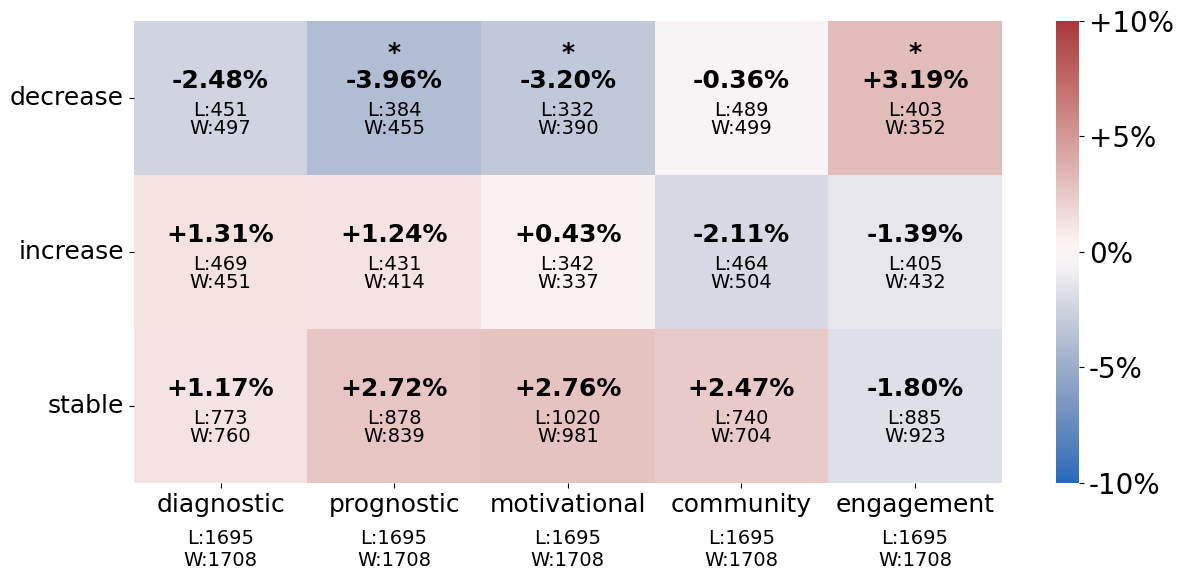

In [105]:
plot_heatmap_robust(summary, losing_deltas_list, winning_deltas_list, order_patterns, order_frames)

## Different seeds for balancing wins and losses

In [70]:
order_patterns = ["decrease", "increase", "stable"]
order_frames = ["diagnostic", "prognotic", "motivational", "community", "engagement"]

In [ ]:
def plot_heatmap_robust(summary, losing_deltas_list, winning_deltas_list, order_patterns, order_frames, significance_threshold=0.8):

    # reshape to matrix for heatmap
    heatmap_matrix = summary.pivot(index="pattern", columns="frame", values="mean_diff")

    # fix patterns and frames order
    heatmap_matrix = heatmap_matrix.reindex(order_patterns, axis=0)
    heatmap_matrix = heatmap_matrix.reindex(order_frames, axis=1)

    
    plt.figure(figsize=(14,6))
    ax = sns.heatmap(
        heatmap_matrix, annot=False, fmt="", cmap="vlag",
        vmin=-0.1, vmax=0.1, center=0
    )

    # get the colorbar and relabel ticks
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.10, -0.05, 0, 0.05, 0.10])
    colorbar.set_ticklabels(["-10%", "-5%", "0%", "+5%", "+10%"], fontsize=20)

    # rotate ticks
    ax.set_xticklabels(["diagnostic", "prognostic", "motivational", "community", "engagement"], rotation=0, fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)

    # add annotations
    for i, pattern in enumerate(heatmap_matrix.index):
        for j, frame in enumerate(heatmap_matrix.columns):
            row = summary[(summary["pattern"]==pattern)&(summary["frame"]==frame)].iloc[0]
            offset = row["mean_diff"]
            star = "*" if row["prop_significant"] >= significance_threshold else ""

            # add offset + star in bold
            ax.text(
                j + 0.5, i + 0.3,  # slightly above center
                f"{star}\n{offset*100:+.2f}%",
                color="black", ha="center", va="center", fontweight="bold", fontsize=18
            )

            # Optionally: show average counts over seeds
            losing_counts = [df[(df['frame']==frame)&(df['delta_diff_category']==pattern)].shape[0] for df in losing_deltas_list]
            winning_counts = [df[(df['frame']==frame)&(df['delta_diff_category']==pattern)].shape[0] for df in winning_deltas_list]
            ax.text(j + 0.5, i + 0.58, f"L:{int(pd.Series(losing_counts).mean())}", ha="center", va="center", fontsize=14)
            ax.text(j + 0.5, i + 0.70, f"W:{int(pd.Series(winning_counts).mean())}", ha="center", va="center", fontsize=14)

    # add totals beneath x tick labels (average across seeds)
    for xtick, frame in zip(ax.get_xticks(), heatmap_matrix.columns):
        losing_totals = [df[df['frame']==frame].shape[0] for df in losing_deltas_list]
        winning_totals = [df[df['frame']==frame].shape[0] for df in winning_deltas_list]
        ax.text(
            xtick,
            len(heatmap_matrix) + 0.3,
            f"L:{int(pd.Series(losing_totals).mean())}\nW:{int(pd.Series(winning_totals).mean())}",
            ha="center", va="top", fontsize=14
        )

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")
    plt.savefig("../plots/usage_before-after_multiseed-balanced.svg", bbox_inches='tight')


In [ ]:
all_results = []
losing_deltas_list = []
winning_deltas_list = []
for seed in range(20):
    # import data
    losing_deltas = pd.read_pickle(f"../data/deltas_5_Losing Election_withcategories.pkl")

    winning_deltas = pd.read_pickle(f"../data/deltas_5_Winning Election_withcategories.pkl")

    losing_deltas["frame"] = losing_deltas["frame_prop"].apply(lambda x: x.split("_")[1])
    winning_deltas["frame"] = winning_deltas["frame_prop"].apply(lambda x: x.split("_")[1])

    losing_deltas["outcome"] = "Losing"
    winning_deltas["outcome"] = "Winning"

    deltas_all = pd.concat([losing_deltas, winning_deltas], ignore_index=True)
    # for each main union, balance the number of cases in losing and winning
    list_union_cases = []
    for union in deltas_all["main_union"].unique():
        # get losing and winning cases for this union
        losing_cases = deltas_all[(deltas_all["main_union"] == union) & (deltas_all["frame_prop"]=="rolling_community_prop") & (deltas_all["outcome"] == "Losing")]["case_number"].unique()
        winning_cases = deltas_all[(deltas_all["main_union"] == union) & (deltas_all["frame_prop"]=="rolling_community_prop") & (deltas_all["outcome"] == "Winning")]["case_number"].unique()

        cases_winning_sub = pd.Series(winning_cases).sample(n=len(losing_cases), random_state=seed).tolist() if len(winning_cases) > len(losing_cases) else list(winning_cases)
        cases_losing_sub = pd.Series(losing_cases).sample(n=len(winning_cases), random_state=seed).tolist() if len(losing_cases) > len(winning_cases) else list(losing_cases)

        list_union_cases += [(union, case, "Winning") for case in cases_winning_sub]
        list_union_cases += [(union, case, "Losing") for case in cases_losing_sub]

    deltas_all_sampled = deltas_all[deltas_all.apply(lambda row: (row["main_union"], row["case_number"], row["outcome"]) in list_union_cases, axis=1)].copy()
    losing_deltas_sampled = deltas_all_sampled[deltas_all_sampled["outcome"] == "Losing"]
    winning_deltas_sampled = deltas_all_sampled[deltas_all_sampled["outcome"] == "Winning"]

    losing_deltas_list.append(losing_deltas_sampled)
    winning_deltas_list.append(winning_deltas_sampled)

    confidence_offset = compute_confidence_offset(losing_deltas_sampled, winning_deltas_sampled, order_patterns, order_frames)
    confidence_offset["seed"] = seed

    all_results.append(confidence_offset)
    
robust_df = pd.concat(all_results, axis=0)

In [80]:
# flag whether each seed is significant
robust_df["significant"] = (robust_df["lower_ci"] > 0) | (robust_df["upper_ci"] < 0)

# aggregate per cell
summary = robust_df.groupby(["pattern", "frame"]).agg(
    mean_diff=("proportion_diff", "mean"),
    prop_significant=("significant", "mean")  # proportion of seeds significant
).reset_index()

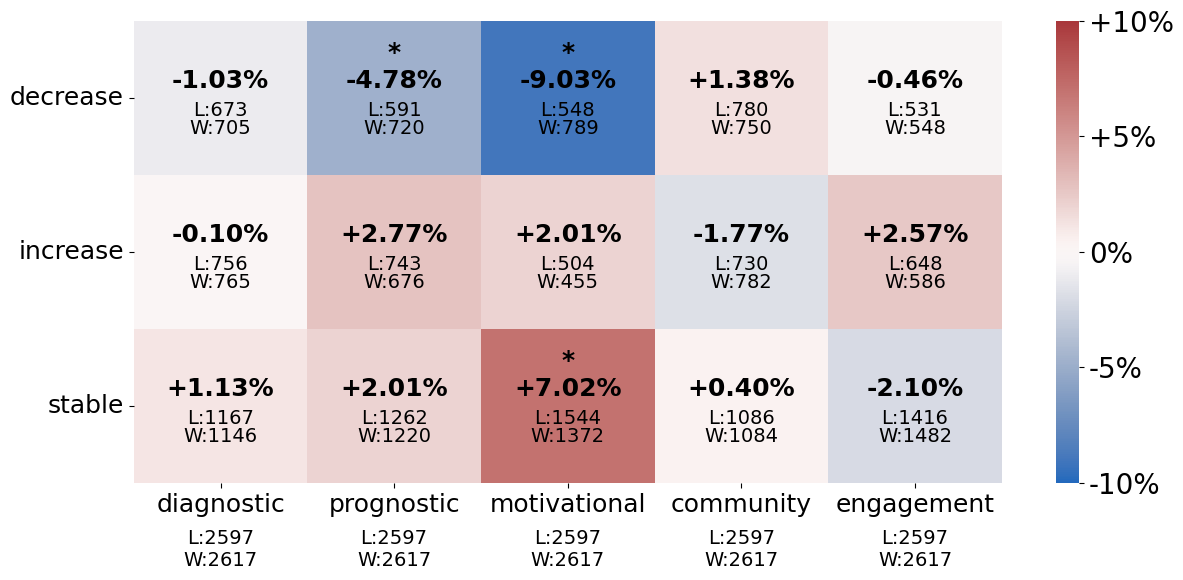

In [82]:
plot_heatmap_robust(summary, losing_deltas_list, winning_deltas_list, order_patterns, order_frames)